# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

# План работ
1. Изучение общей информации о данных
2. Работа с пропусками и дубликатами
3. Добавление новых столбцов для последующего анализа
4. Проверка выбросов
5. Исследование факторов, влияющих на стоимость квартиры

### Общая информация

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv(r"D:\Загрузки\real_estate_data.csv", sep='	') #читаем данные, заметили другой разделитель
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Нашли количество ненулевых значений в каждом столбце. Переименуем столбец 'cityCenters_nearest' в соответствии с правилами хорошего кода

In [4]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)

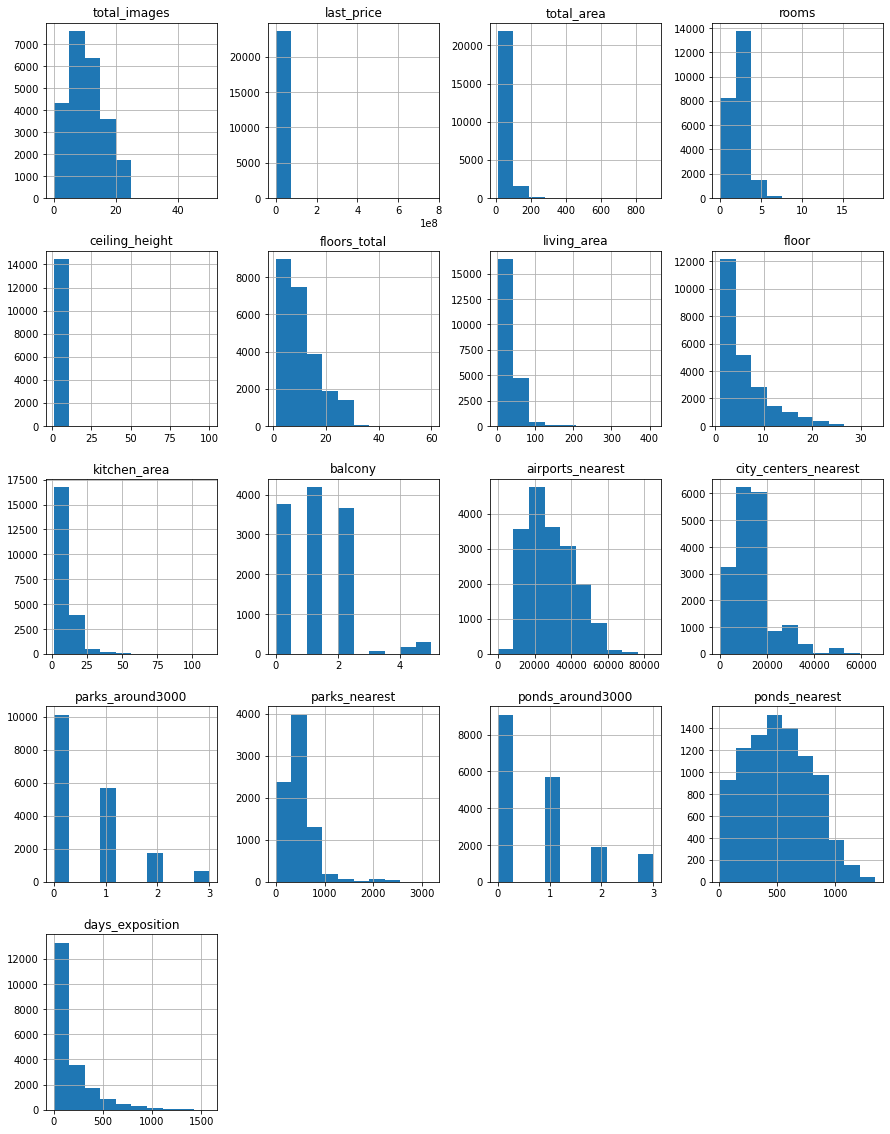

In [5]:
data.hist(figsize=(15, 20))
plt.show()

# Вывод 

Видим несоответствие типов данных в столбцах 'is_apartment', 'balcony', 'first_day_exposition', 'floors_total'. 

На гистограммах сразу можно отметить наличие выбросов в нескольких столбцах: 'last_price', 'total_area', 'rooms', 'ceiling_height', living_area', 'kitchen_area'.

### Предобработка данных

In [98]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            386
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2164
balcony                     0
locality_name               0
airports_nearest         5436
city_centers_nearest     5415
parks_around3000         5414
parks_nearest           15225
ponds_around3000         5414
ponds_nearest           14259
days_exposition          3031
price_per_sq_meter          0
day_of_week                 0
month                       0
year                        0
city_centre_km           5415
floor_type                  0
dtype: int64

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пропущенные значения, %' + "\n", fontsize = 22)    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

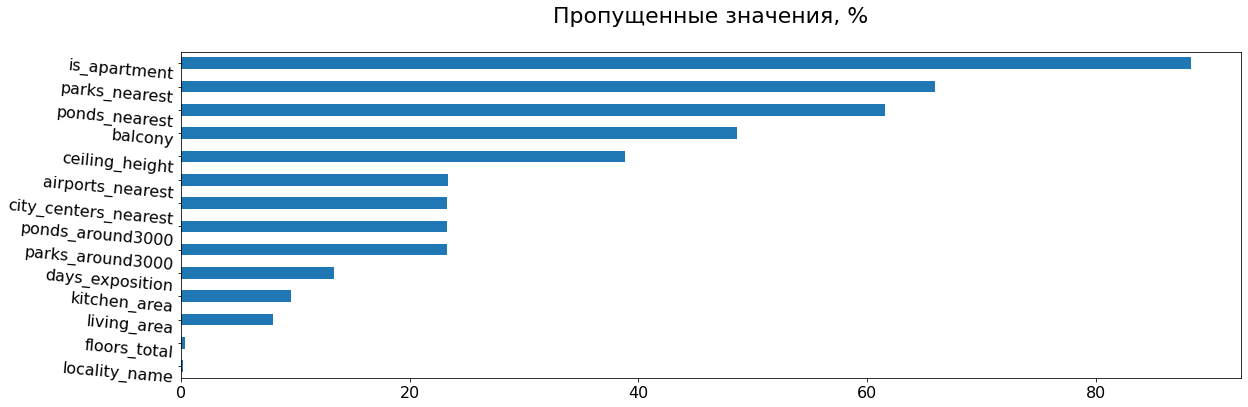

In [8]:
pass_value_barh(data)

In [9]:
# Удалим строки с пропущенными занчениями в столбцах 'locality_name' и 'floors_total', т.к. их немного 
#и пока непонятно, как их заполнить
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)

Заметно, что в столбце 'ceiling_height' есть аномально большие значения.

Заменим пропущенные значения в этом столбце на медианные в группе. Можно предположить, что высота потолков зависит от района и от количества этажей в самом доме. Поэтому сгруппируем по этим двум колонкам и посчитаем в них медианное значение, затем заполним ими пропуски

In [10]:
data['ceiling_height'] = (data['ceiling_height']
    .fillna(data.groupby(['floors_total', 'locality_name'])['ceiling_height']
    .transform('median')))
#некоторые значения все еще остались пустыми, оставим так

Заполним пропуски и изменим тип в некотрых столбцах. 
1. 'is_apartment' - скорее всего не является апартаментами, поэтому заполним значением False, изменим тип на bool
2. 'balcony' - скорее всего балконов нет, поэтому ставим 0, заменим тип данных на целочисленный
3. 'first_day_exposition' - поменяем формат на дату без врмени, т.к. везде указано 00:00:00
4. 'floors_total' - тоже только целые числа могут быть этажами
5. 'living_area' заполним из расчета средней площади одной комнаты

In [11]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype('bool')
data['balcony'] = data['balcony'].fillna(0).astype('int') 
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['floors_total'] = data['floors_total'].astype('int')

Посмотрим, какая в среднем площадь одной комнаты. 

In [12]:
pivot_data = data.pivot_table(index='rooms', values='living_area').reset_index()
one_room_sq = round(pivot_data['living_area'].sum()/pivot_data['rooms'].sum())

Заполним пропуски в жилой площади следующим образом: количество комнат умножим на среднюю площадь одной комнаты.

In [13]:
data['living_area'] = (data['living_area']
    .fillna(data['rooms']*one_room_sq))

Столбец 'kitchen_area' оставим без изменений

In [14]:
data.query('total_area*0.9 <= (living_area + kitchen_area)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
41,16,7900000.0,74.0,2016-05-04,3,2.60,14,59.0,8,False,...,12.0,5,Санкт-Петербург,37715.0,12612.0,1.0,725.0,1.0,759.0,179.0
171,6,3800000.0,49.0,2019-02-22,2,2.50,9,38.0,8,False,...,10.0,1,посёлок Шушары,18471.0,24272.0,0.0,NaN,0.0,NaN,11.0
184,7,2600000.0,30.2,2018-02-14,1,2.65,9,26.1,5,False,...,6.2,0,Санкт-Петербург,13952.0,15031.0,0.0,NaN,1.0,824.0,12.0
220,8,3890000.0,37.0,2018-07-09,1,2.50,25,28.0,6,False,...,9.0,0,Санкт-Петербург,25408.0,16166.0,0.0,NaN,0.0,NaN,28.0
319,19,4850000.0,59.7,2015-03-19,3,2.50,5,47.4,4,False,...,6.4,1,Санкт-Петербург,43095.0,15599.0,0.0,NaN,0.0,NaN,974.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23328,12,4299000.0,54.0,2016-11-25,2,2.50,14,40.0,8,False,...,10.0,0,Колпино,25612.0,31399.0,0.0,NaN,0.0,NaN,343.0
23423,8,2450000.0,48.0,2017-08-29,2,2.75,5,38.0,5,False,...,9.0,1,поселок городского типа Приладожский,NaN,NaN,NaN,NaN,NaN,NaN,391.0
23521,13,8500000.0,65.0,2018-11-01,2,3.00,4,44.0,2,False,...,15.3,0,Санкт-Петербург,22276.0,3996.0,1.0,627.0,0.0,NaN,NaN
23584,17,2450000.0,66.0,2019-04-03,3,2.50,5,57.0,1,False,...,8.0,0,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Получили следующие результаты. Необработанными остались пропуски в колонках 'airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest'. В 'ceiling_height' еще остались пропуски. Оставим так, чтобы случайно не ухушить информацию.

Пропуски в столбцах 'parks_nearest' и 'ponds_nearest' замечены в строках, где 'parks_around3000' и 'ponds_around3000' соответственно равны нулю. Парков и водоемов нет - значит и расстояние до них никак не указать.



In [15]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height            392
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

In [16]:
data.duplicated().sum() # явных дубликатов нет, посмотрим неявные
sorted(data['locality_name'].unique())
data['locality_name'] = data['locality_name'].str.lower()

In [17]:
# заменим похожие названия
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['городской поселок ', 'поселок городского типа ', 'поселок ', 'деревня ', 'село '], '', regex=True)
)

len(sorted(data['locality_name'].unique())) # посмотрим количество уникальных значений после преобразований

311

In [18]:
data.duplicated().sum()

0

#### check name

In [19]:
# check
data.locality_name.nunique()

311

In [20]:
# check
sorted(data.locality_name.unique())

['агалатово',
 'александровская',
 'алексеевка',
 'аннино',
 'аро',
 'барышево',
 'батово',
 'бегуницы',
 'белогорка',
 'белоостров',
 'бокситогорск',
 'большая вруда',
 'большая ижора',
 'большая пустомержа',
 'большие колпаны',
 'большое рейзино',
 'большой сабск',
 'бор',
 'борисова грива',
 'бугры',
 'будогощь',
 'ваганово',
 'важины',
 'вартемяги',
 'вахнова кара',
 'виллози',
 'вознесенье',
 'возрождение',
 'войсковицы',
 'войскорово',
 'володарское',
 'волосово',
 'волхов',
 'всеволожск',
 'выборг',
 'вырица',
 'выскатка',
 'высокоключевой',
 'высоцк',
 'гаврилово',
 'гарболово',
 'гатчина',
 'гладкое',
 'глажево',
 'глебычево',
 'глинка',
 'гончарово',
 'горбунки',
 'гостилицы',
 'громово',
 'дзержинского',
 'дружная горка',
 'дружноселье',
 'дубровка',
 'елизаветино',
 'ефимовский',
 'жилгородок',
 'жилпоселок',
 'житково',
 'заводской',
 'заклинье',
 'заневка',
 'запорожское',
 'зеленогорск',
 'зимитицы',
 'ивангород',
 'извара',
 'ильичево',
 'имени морозова',
 'имени свердл

# Вывод

Заменили пропущенные значения там, где это возможно. Незаполненными остались колонки:
1. 'ceiling_height' - оставим так, чтобы случайно не испортить информацию, к тому же, их немного; 
2. 'airports_nearest', 'city_centers_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' - Для каждой квартиры эти данные уникальные, нельзя их просто заполнить медианой или средним, + они не сильно влияют на анлиз;
3. 'days_exposition' - возможно объявление еще не снято с продажи, заменить пропуски не можем.
4. 'kitchen_area'

Избавились от дубликатов. Изменили типы данных в некоторых столбцах.

### Добавление новых столбцов

In [21]:
data['price_per_sq_meter'] = (data['last_price']/data['total_area']).round(decimals=2) # создаем столбец с ценой 1 кв.м.
data['day_of_week'] = data['first_day_exposition'].dt.weekday # столбец с днем недели, когда было опубликовано объявление
data['month'] = data['first_day_exposition'].dt.month #  месяц публикации
data['year'] = data['first_day_exposition'].dt.year # год публикации объявления
data['city_centre_km'] = (data['city_centers_nearest']/1000).round() # расстояния до центра в км

In [22]:
def floor_type (row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    if row['floor']<1:
        return 'неверно указан этаж'
    return 'другой'

data['floor_type'] = data.apply(floor_type, axis=1) # столбец с типом этажа

In [23]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_meter,day_of_week,month,year,city_centre_km,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.37,3,3,2019,16.0,другой
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,19.0,первый
2,10,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,14.0,другой
3,0,64900000.0,159.0,2015-07-24,3,2.60,14,57.0,9,False,...,84.0,3.0,234.0,424.0,408176.10,4,7,2015,7.0,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.00,1,6,2018,8.0,другой


### Исследовательский анализ данных

#### Аномальные значения

Заметны явные выбросы, в которых общая площадь свыше 550 метров, их немного, поэтому можем их удалить.

In [24]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

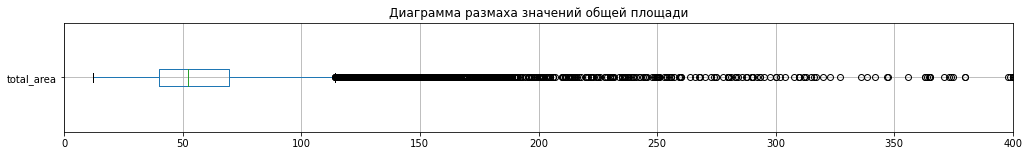

In [25]:
# check

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений общей площади')
ax.set_xlim(0, 400);

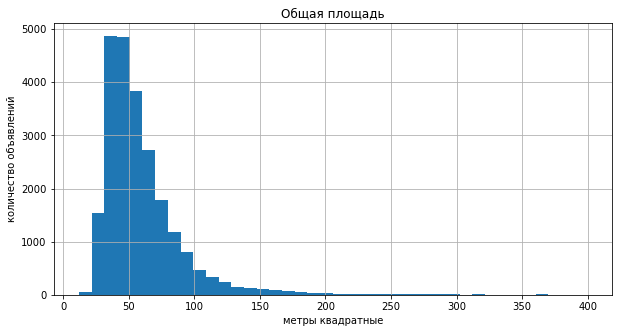

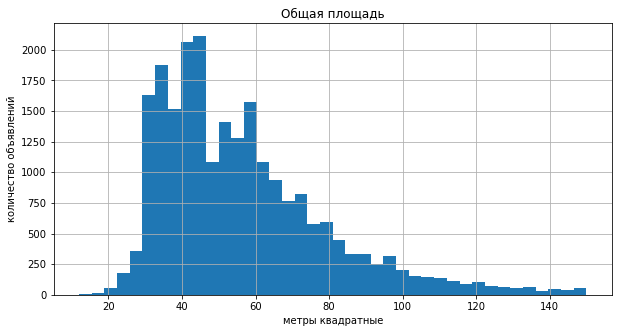

In [26]:
data=data.query('total_area<400')
data['total_area'].hist(bins=40, figsize=(10, 5))
plt.title('Общая площадь')
plt.xlabel('метры квадратные')
plt.ylabel('количество объявлений')
plt.show()

data['total_area'].hist(bins=40, range=(12,150), figsize=(10, 5))
plt.title('Общая площадь')
plt.xlabel('метры квадратные')
plt.ylabel('количество объявлений')
plt.show()

data.reset_index(drop= True , inplace= True )

In [27]:
data['living_area'].describe()

count    23539.000000
mean        34.614666
std         20.709241
min          0.000000
25%         19.000000
50%         30.300000
75%         42.600000
max        264.500000
Name: living_area, dtype: float64

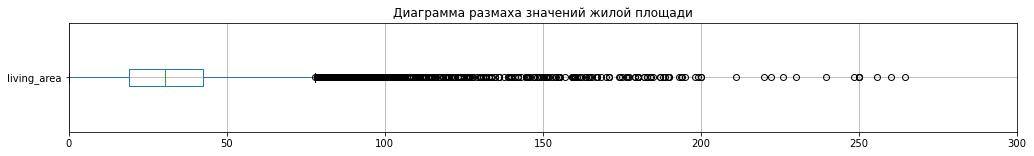

In [28]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений жилой площади')
ax.set_xlim(0, 300);

Жилая зона с площадью 200 м встречается нечасто - скорее всего выбросы. Удалим их. Также есть очень маленькая площадь жилой зоны - 2 м. Оставим только те строки, в которых жилая зона не менее 10 метров.

##### check nan

In [29]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23539 entries, 0 to 23538
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23539 non-null  int64         
 1   last_price            23539 non-null  float64       
 2   total_area            23539 non-null  float64       
 3   first_day_exposition  23539 non-null  datetime64[ns]
 4   rooms                 23539 non-null  int64         
 5   ceiling_height        23147 non-null  float64       
 6   floors_total          23539 non-null  int32         
 7   living_area           23539 non-null  float64       
 8   floor                 23539 non-null  int64         
 9   is_apartment          23539 non-null  bool          
 10  studio                23539 non-null  bool          
 11  open_plan             23539 non-null  bool          
 12  kitchen_area          21322 non-null  float64       
 13  balcony         

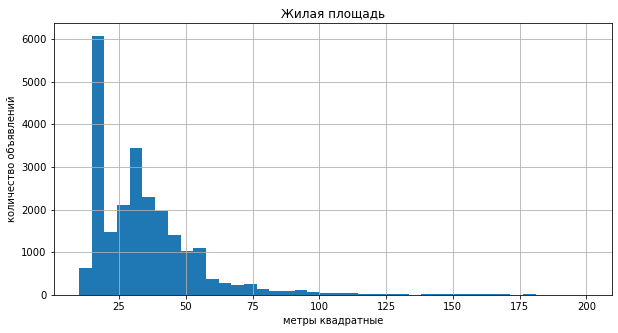

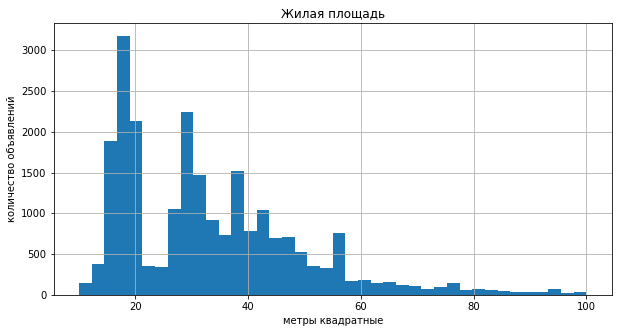

In [30]:
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)
data['living_area'].hist(bins=40, figsize=(10, 5))
plt.title('Жилая площадь')
plt.xlabel('метры квадратные')
plt.ylabel('количество объявлений')
plt.show()

data['living_area'].hist(bins=40, range=(10, 100), figsize=(10, 5))
plt.title('Жилая площадь')
plt.xlabel('метры квадратные')
plt.ylabel('количество объявлений')
plt.show()

data.reset_index(drop= True , inplace= True )

In [31]:
# check
data.shape[0]

23490

In [32]:
data['kitchen_area'].describe()

count    21288.000000
mean        10.506039
std          5.705813
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

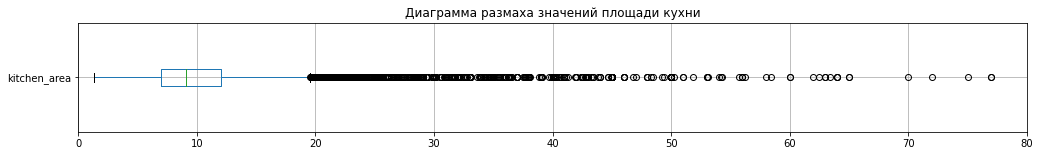

In [33]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади кухни')
ax.set_xlim(0, 80);

Площадь кухни более 40 метров - странно. Значения скорее всего являются аномальными. Также площадь кухни должна составлять не менее 5 м.

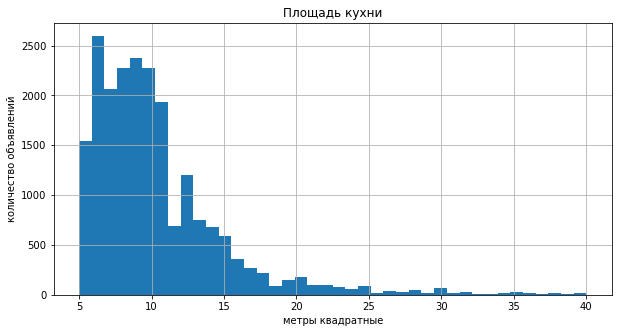

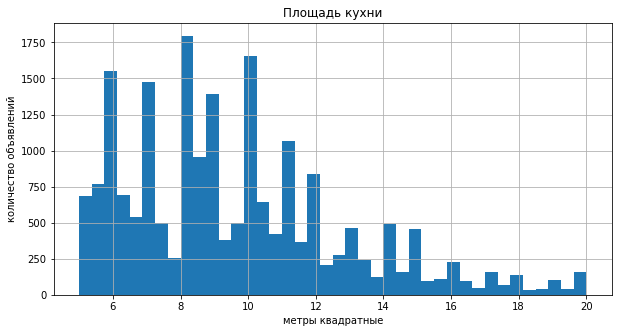

In [34]:
data.drop(index=data.query('kitchen_area > 40').index,inplace=True)
data.drop(index=data.query('kitchen_area < 5').index,inplace=True)
data['kitchen_area'].hist(bins=40, figsize=(10, 5))
plt.title('Площадь кухни')
plt.xlabel('метры квадратные')
plt.ylabel('количество объявлений')
plt.show()

data['kitchen_area'].hist(bins=40, range=(5, 20), figsize=(10, 5))
plt.title('Площадь кухни')
plt.xlabel('метры квадратные')
plt.ylabel('количество объявлений')
plt.show()

data.reset_index(drop= True , inplace= True )

In [35]:
data['kitchen_area'].describe()

count    21069.000000
mean        10.315642
std          4.760555
min          5.000000
25%          7.000000
50%          9.100000
75%         12.000000
max         40.000000
Name: kitchen_area, dtype: float64

In [36]:
print(data['last_price'].describe())
print(data.query('last_price <100000'))

count    2.327100e+04
mean     6.231389e+06
std      7.556823e+06
min      4.300000e+05
25%      3.420000e+06
50%      4.600000e+06
75%      6.700000e+06
max      3.300000e+08
Name: last_price, dtype: float64
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, price_per_sq_meter, day_of_week, month, year, city_centre_km, floor_type]
Index: []

[0 rows x 28 columns]


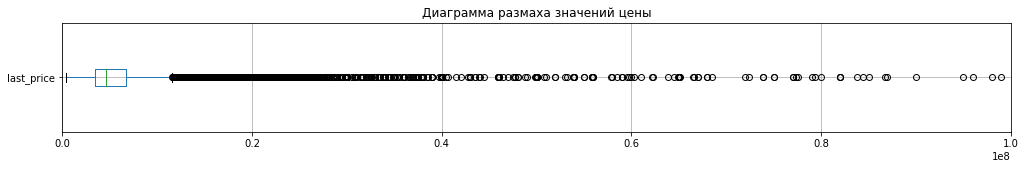

In [37]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['last_price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений цены')
ax.set_xlim(0, 100000000);

Удалим слишком дорогие квартиры - более 80.000.000. Также есть одно слишком маленькое значение, удалим его тоже

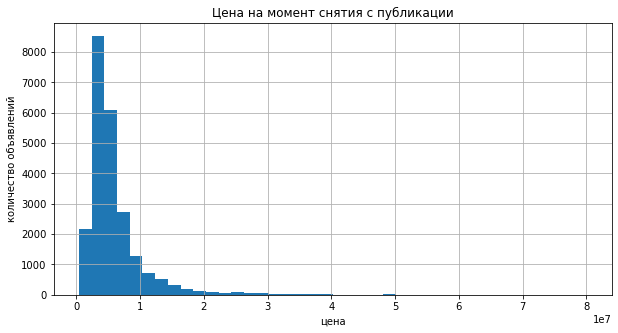

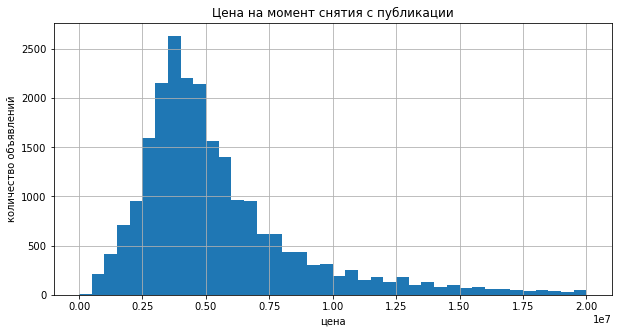

In [38]:
data.drop(index=data.query('last_price < 100000').index,inplace=True)
data.drop(index=data.query('last_price > 80000000').index,inplace=True)
data['last_price'].hist(bins=40, figsize=(10, 5))
plt.title('Цена на момент снятия с публикации')
plt.xlabel('цена')
plt.ylabel('количество объявлений')
plt.show()

data['last_price'].hist(bins=40, range=(0, 20000000), figsize=(10, 5))
plt.title('Цена на момент снятия с публикации')
plt.xlabel('цена')
plt.ylabel('количество объявлений')
plt.show()

data.reset_index(drop= True , inplace= True )

count    23239.000000
mean         2.056758
std          1.044458
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64


<AxesSubplot:>

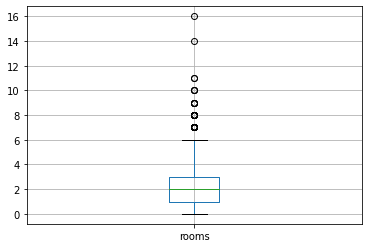

In [39]:
print(data['rooms'].describe())
data.boxplot('rooms')

Удалим квартиры, где количество комнат больше 6.

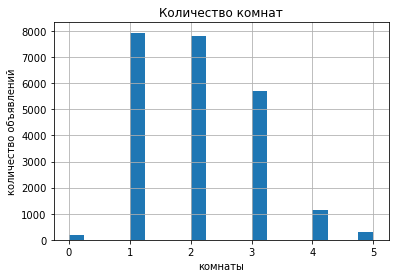

In [40]:
data.drop(index=data.query('rooms>=6').index,inplace=True)
data['rooms'].hist(bins=20)
plt.title('Количество комнат')
plt.xlabel('комнаты')
plt.ylabel('количество объявлений')
plt.show()

In [41]:
print(data['ceiling_height'].describe())

count    22695.000000
mean         2.733590
std          1.025277
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64


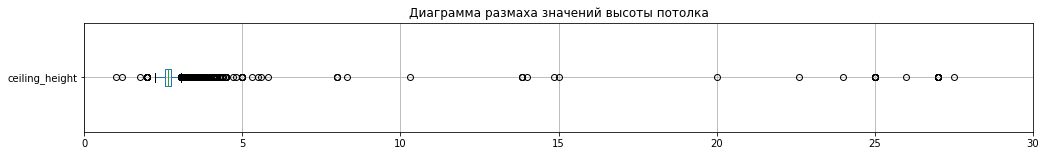

In [42]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['ceiling_height']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений высоты потолка')
ax.set_xlim(0, 30);

Там, где потолки выше 25 м, скорее всего опечатка. Поделим это значения на 10

In [43]:
data.loc[data['ceiling_height'] > 25, 'ceiling_height'] = data['ceiling_height']/10

In [44]:
print(data['ceiling_height'].describe())

count    22695.000000
mean         2.716399
std          0.549921
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max         25.000000
Name: ceiling_height, dtype: float64


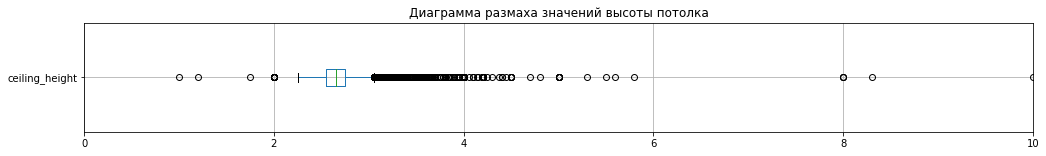

In [45]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['ceiling_height']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений высоты потолка')
ax.set_xlim(0, 10);

Теперь видны явные отклонения. Будем работать с данными, где высота потолков не ниже 2.5 метров и не выше 5

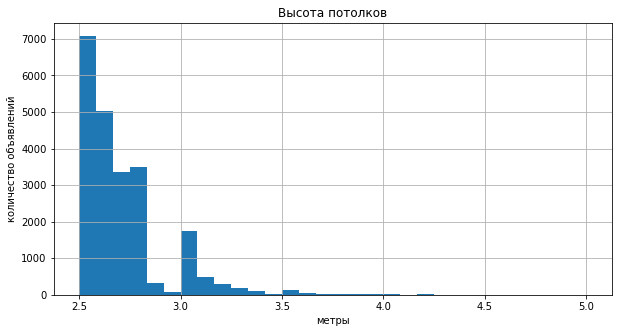

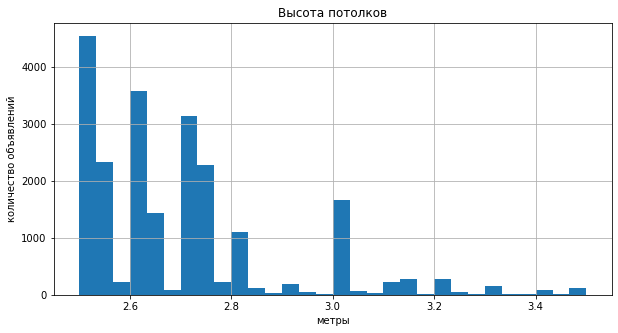

In [46]:
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)
data.drop(index=data.query('ceiling_height > 5').index,inplace=True)
data['ceiling_height'].hist(bins=30, figsize=(10, 5))
plt.title('Высота потолков')
plt.xlabel('метры')
plt.ylabel('количество объявлений')
plt.show()

data['ceiling_height'].hist(bins=30, range=(2.5, 3.5), figsize=(10, 5))
plt.title('Высота потолков')
plt.xlabel('метры')
plt.ylabel('количество объявлений')
plt.show()

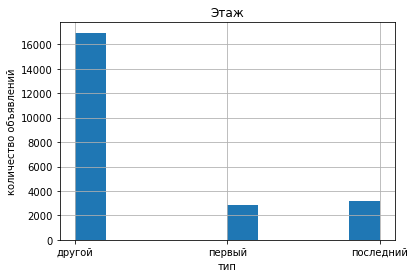

In [47]:
data['floor_type'].hist()
plt.title('Этаж')
plt.xlabel('тип')
plt.ylabel('количество объявлений')
plt.show()

Большинство квартир находятся ни на первом, ни на последнем этаже - звучит логично.

count    22983.000000
mean        10.751207
std          6.601554
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


<AxesSubplot:>

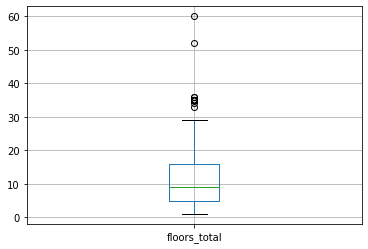

In [48]:
print(data['floors_total'].describe())
data.boxplot('floors_total')

Удалим строки, где количество этажей в доме больше 30.

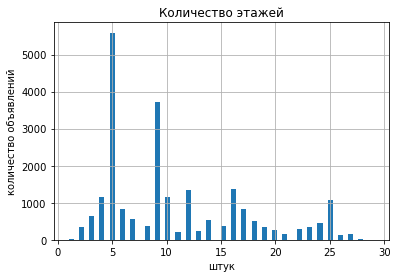

In [49]:
data=data.query('floors_total<30')
data['floors_total'].hist(bins=30*2)
plt.title('Количество этажей')
plt.xlabel('штук')
plt.ylabel('количество объявлений')
plt.show()

In [50]:
print(data['city_centers_nearest'].describe())

count    17539.000000
mean     14302.983408
std       8564.271231
min        181.000000
25%       9496.000000
50%      13164.000000
75%      16313.500000
max      65968.000000
Name: city_centers_nearest, dtype: float64


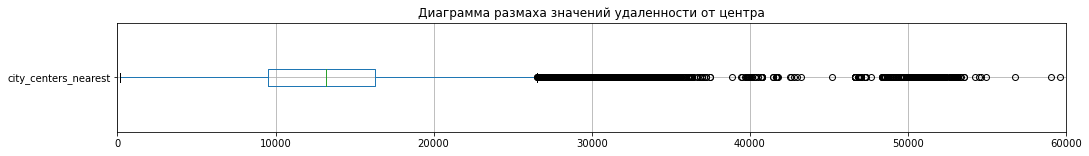

In [51]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['city_centers_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений удаленности от центра')
ax.set_xlim(0, 60000);

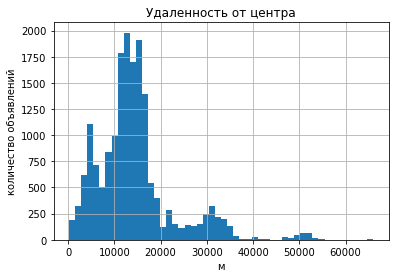

In [52]:
data['city_centers_nearest'].hist(bins=50)
plt.title('Удаленность от центра')
plt.xlabel('м')
plt.ylabel('количество объявлений')
plt.show()

In [53]:
print(data['parks_nearest'].describe())

count    7729.000000
mean      492.573425
std       343.062087
min         1.000000
25%       288.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64


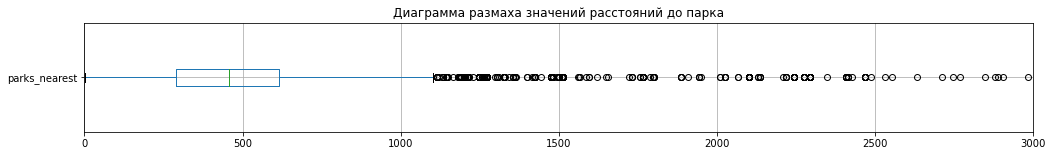

In [54]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['parks_nearest']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений расстояний до парка')
ax.set_xlim(0, 3000);

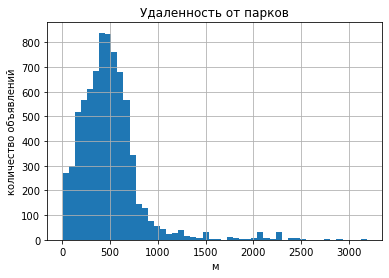

In [55]:
data['parks_nearest'].hist(bins=50)
plt.title('Удаленность от парков')
plt.xlabel('м')
plt.ylabel('количество объявлений')
plt.show()

Оставим эти значения как есть, ведь квартиры действительно могут располагаться далеко от центра или парков. К тому же они не будут исследоваться дальше, поэтому не мешают.

#### check gap

In [56]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22954 entries, 0 to 23238
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22954 non-null  int64         
 1   last_price            22954 non-null  float64       
 2   total_area            22954 non-null  float64       
 3   first_day_exposition  22954 non-null  datetime64[ns]
 4   rooms                 22954 non-null  int64         
 5   ceiling_height        22568 non-null  float64       
 6   floors_total          22954 non-null  int32         
 7   living_area           22954 non-null  float64       
 8   floor                 22954 non-null  int64         
 9   is_apartment          22954 non-null  bool          
 10  studio                22954 non-null  bool          
 11  open_plan             22954 non-null  bool          
 12  kitchen_area          20790 non-null  float64       
 13  balcony         

In [57]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,954.00","22,954.00","22,568.00","19,923.00","22,954.00","22,954.00","20,790.00","22,954.00","22,954.00"
min,0.00,12.00,2.50,1.00,"430,000.00",10.00,5.00,1.00,1.00
max,5.00,365.00,5.00,"1,580.00","80,000,000.00",200.00,40.00,27.00,29.00
median,2.00,51.70,2.65,94.00,"4,600,000.00",30.10,9.00,4.00,9.00


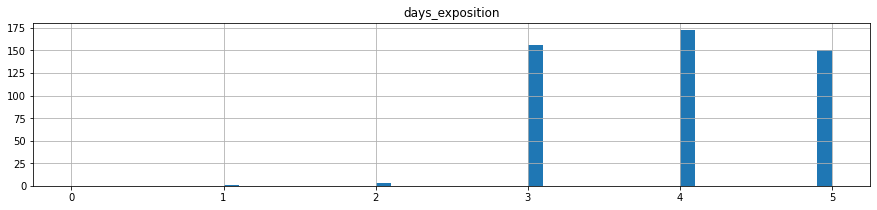

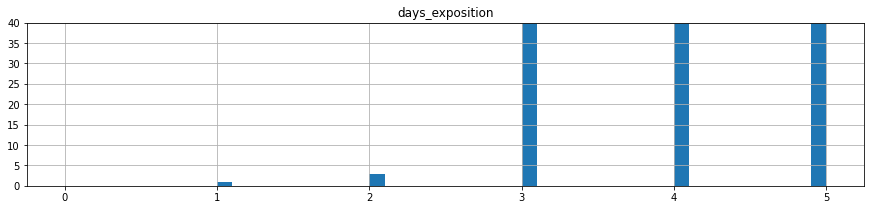

In [58]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

In [59]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [60]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


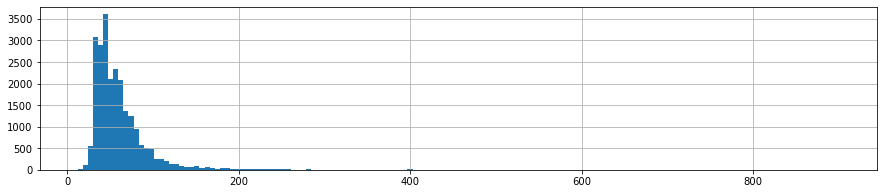

In [61]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

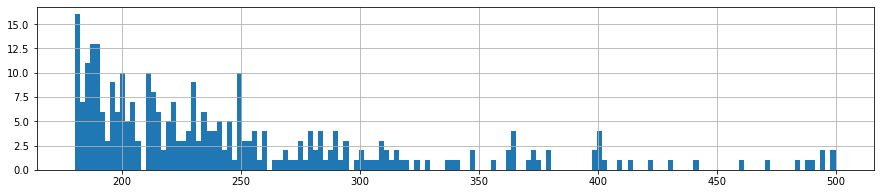

In [62]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

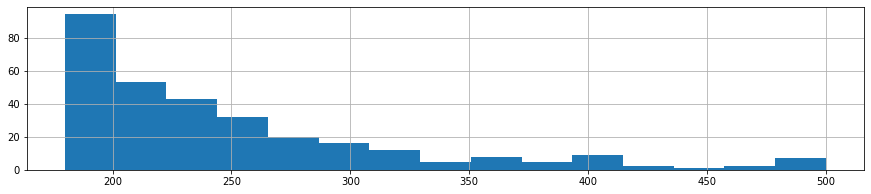

In [63]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

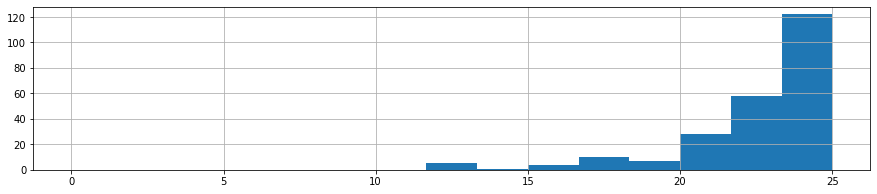

In [64]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [65]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,20.05,2.50,3.00,"562,718.00",10.00,5.00,1.00,2.00
0.01,1.00,26.00,2.50,4.00,"1,000,000.00",13.50,5.00,1.00,2.00
0.5,2.00,51.70,2.65,94.00,"4,600,000.00",30.10,9.00,4.00,9.00
0.99,5.00,160.75,3.53,"1,065.00","27,844,700.00",95.00,30.00,22.00,26.00
0.9988,5.00,235.46,4.20,"1,368.47","59,000,000.00",145.00,39.00,26.00,27.00


#### check

count    19923.000000
mean       179.688149
std        218.793471
min          1.000000
25%         45.000000
50%         94.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

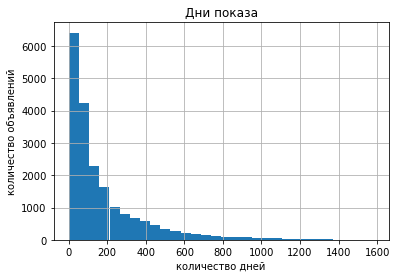

In [66]:
data['days_exposition'].hist(bins=30)
display(data['days_exposition'].describe())
plt.title('Дни показа')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

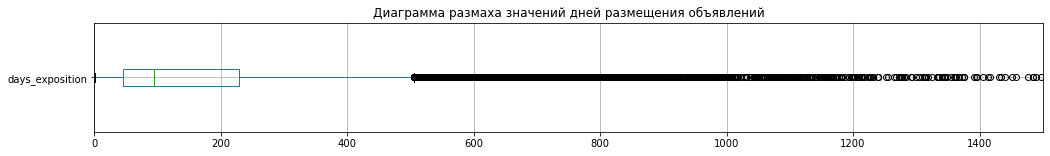

In [67]:
fig, ax = plt.subplots(figsize = (17,2))
ax = data[['days_exposition']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений дней размещения объявлений')
ax.set_xlim(0, 1500);

Среднее значение почти в два раза больше медианного. Значит, есть квартиры, которые продавались очень долго, а есть и те, что продались за один день. Посмотрим гистограмму поближе в промежутке до 500 дней

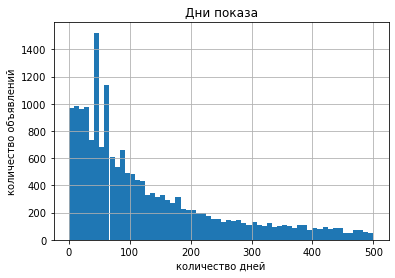

In [68]:
data['days_exposition'].hist(bins=60, range=(0,500))
plt.title('Дни показа')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

В основном квартиры продаются достаточно быстро: около 100 дней. Слишком быстрые продажи - до 45 дней. А квартиры, которые продаются дольше 230 дней будем считать слишком долгими продажами.

Заметны также, что много квартир сниаются с продажи через 45, 60 и 90 дней.

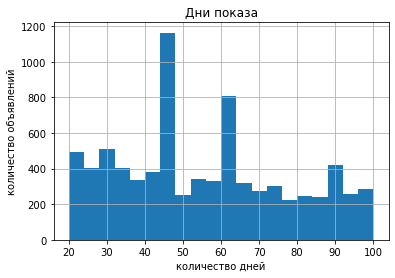

In [69]:
data['days_exposition'].hist(bins=20, range=(20,100))
plt.title('Дни показа')
plt.xlabel('количество дней')
plt.ylabel('количество объявлений')
plt.show()

In [70]:
data.reset_index(drop= True , inplace= True )

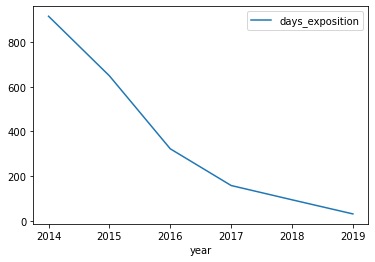

In [71]:
(data
    .pivot_table(index='year', values='days_exposition')
    .plot())
plt.show()

Среднее время продажи квартир сильно упало с 2014 года

#### Факторы, которые больше всего влияют на общую (полную) стоимость объекта

0.75


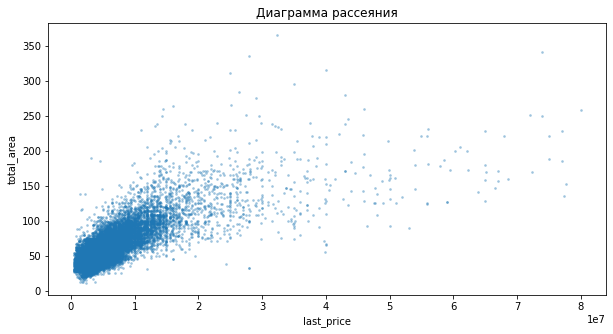

In [72]:
print(data['last_price'].corr(data['total_area']).round(decimals=2))
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.3, s=3, figsize=(10,5))
plt.title('Диаграмма рассеяния')
plt.show()

Заметна тенденция - чем больше общая площадь, тем выше цена объекта

0.63


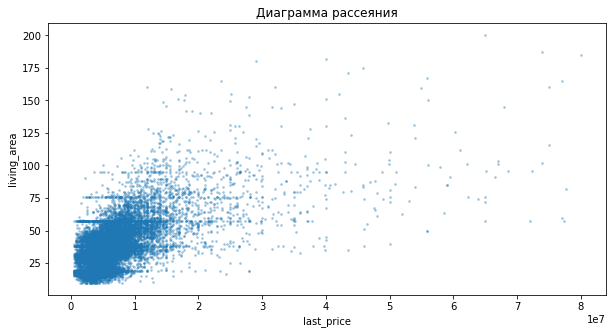

In [73]:
print(data['last_price'].corr(data['living_area']).round(decimals=2))
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.3, s=3, figsize=(10,5))
plt.title('Диаграмма рассеяния')
plt.show()

Этим параметрам присуща не такая сильная связь, но в целом заметно: там, где жилая площадь выше, цена также стремится к более высокому значению.

0.55


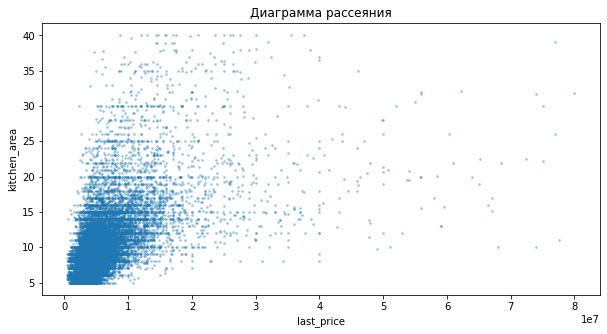

In [74]:
print(data['last_price'].corr(data['kitchen_area']).round(decimals=2))
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.3, s=3, figsize=(10,5))
plt.title('Диаграмма рассеяния')
plt.show()

С кухней также

In [75]:
data.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median', 'count'])

,mean,median,count
,last_price,last_price,last_price
rooms,,,
0,2.988166e+06,2700000.0,179
1,3.829647e+06,3600000.0,7900
2,5.515485e+06,4770338.0,7763
3,7.801176e+06,6177643.0,5683
4,1.194826e+07,8950000.0,1133
5,1.689718e+07,13000000.0,296


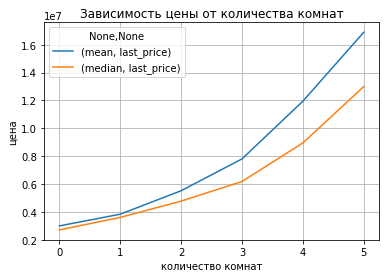

In [76]:
data.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median']).plot(grid=True)
plt.title('Зависимость цены от количества комнат')
plt.xlabel('количество комнат')
plt.ylabel('цена')
plt.show()

0.4427677125143332


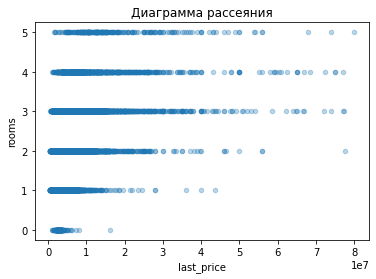

In [77]:
print(data['last_price'].corr(data['rooms']))
data.plot(x='last_price', y='rooms', kind='scatter', alpha=0.3)
plt.title('Диаграмма рассеяния')
plt.show()

Если мы рассматриваем среднюю или медианную цену квартиры в зависимости от количества комнат, то можно отметить, что между ценой и количеством комнат существует прямая зависимость.

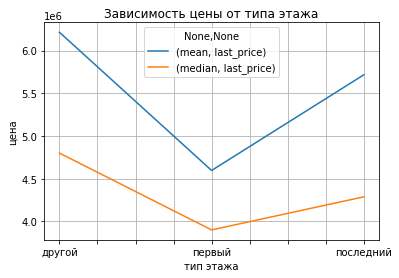

In [78]:
data.pivot_table(index='floor_type', values='last_price', aggfunc=['mean', 'median']).plot(grid=True)
plt.title('Зависимость цены от типа этажа')
plt.xlabel('тип этажа')
plt.ylabel('цена')
plt.show()

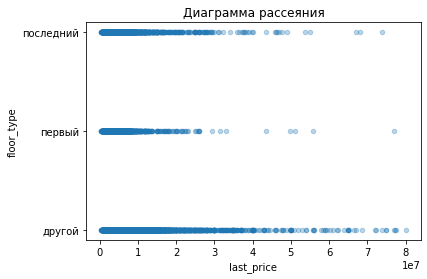

In [79]:
data.plot(x='last_price', y='floor_type', kind='scatter', alpha=0.3)
plt.title('Диаграмма рассеяния')
plt.show()

Большинство квартир, находящиеся на первом или последнем этажах не стоят дороже 50.000.000. Логично, люди более склонны к покупке квартиры на другом этаже, нежели на первом или на последнем.

In [80]:
data.pivot_table(index='day_of_week', values='last_price', aggfunc=['mean', 'median', 'count'])

,mean,median,count
,last_price,last_price,last_price
day_of_week,,,
0,5.945273e+06,4600000.0,3498
1,5.917328e+06,4700000.0,4069
2,6.013805e+06,4690000.0,3840
3,6.111521e+06,4600000.0,4142
4,5.876551e+06,4550000.0,3890
5,5.820275e+06,4500000.0,1878
6,5.746772e+06,4500000.0,1637


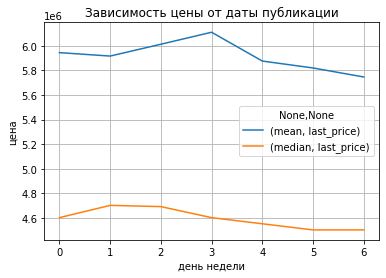

In [81]:
data.pivot_table(index='day_of_week', values='last_price', aggfunc=['mean', 'median']).plot(grid=True)
plt.title('Зависимость цены от даты публикации')
plt.xlabel('день недели')
plt.ylabel('цена')
plt.show()

Медианное значение не сильно отличается в зависимости от дня недели, но среднее значение цены больше в среду.

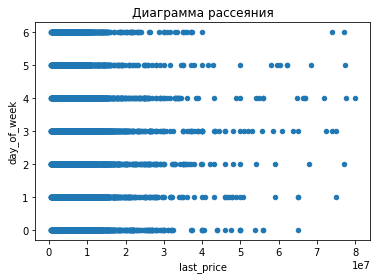

In [82]:
data.plot(x='last_price', y='day_of_week', kind='scatter')
plt.title('Диаграмма рассеяния')
plt.show()

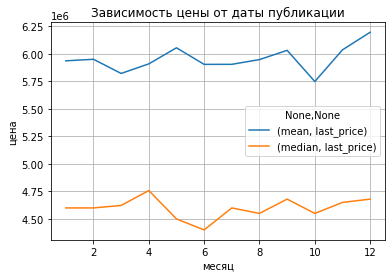

In [83]:
data.pivot_table(index='month', values='last_price', aggfunc=['mean', 'median']).plot(grid=True)
plt.title('Зависимость цены от даты публикации')
plt.xlabel('месяц')
plt.ylabel('цена')
plt.show()

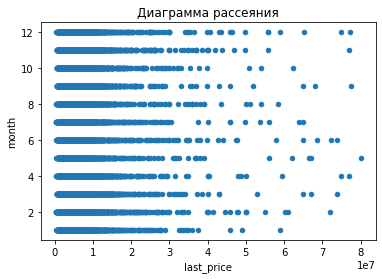

In [84]:
data.plot(x='last_price', y='month', kind='scatter')
plt.title('Диаграмма рассеяния')
plt.show()

Зависимость между месяцем публикации и ценой не наблюдается

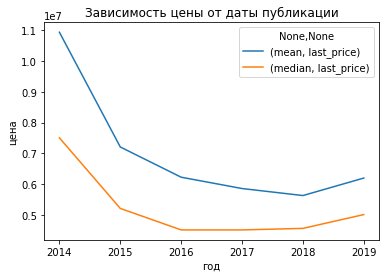

In [85]:
data.pivot_table(index='year', values='last_price', aggfunc=['mean', 'median']).plot()
plt.title('Зависимость цены от даты публикации')
plt.xlabel('год')
plt.ylabel('цена')
plt.show()

Можно отметить, что цены на квартиры в 2014 году были самими высокими

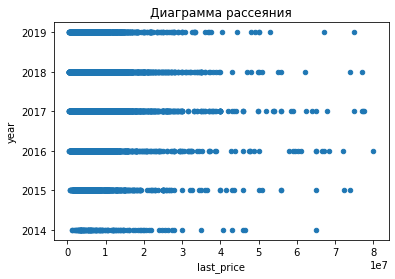

In [86]:
data.plot(x='last_price', y='year', kind='scatter')
plt.title('Диаграмма рассеяния')
plt.show()

In [87]:
data.pivot_table(index='year', values=['last_price', 'total_area'], aggfunc=['mean', 'count'])

mean                 count           
        last_price total_area last_price total_area
year                                               
2014  1.094121e+07  82.759771        131        131
2015  7.202306e+06  67.617103       1122       1122
2016  6.217579e+06  60.410597       2678       2678
2017  5.848551e+06  58.116655       7952       7952
2018  5.619762e+06  56.218608       8283       8283
2019  6.189992e+06  56.808067       2788       2788

На цену объекта влияют следующие факторы:
1. Общая площадь - прямая зависимость
2. Жилая площадь - прямая зависимость
3. Количество комнат - прямая зависимость
4. Тип этажа - квартиры на первом этаже стоят дешевле
5. Год - после 2014 года цены на жилье стали падать. Благодаря сводной таблице можно заметить, что вместе со средней ценой уменьшается и общая площадь продаваемых квартир, а количество объявлений о продажах до 2019 года растет.

#### Цены за квадратный метр

In [88]:
top_10_data=(data
    .pivot_table(index='locality_name', values='price_per_sq_meter', aggfunc=['mean', 'count'])
    .droplevel(1, axis=1)
    .sort_values(by='count', ascending=False)
    .head(10))

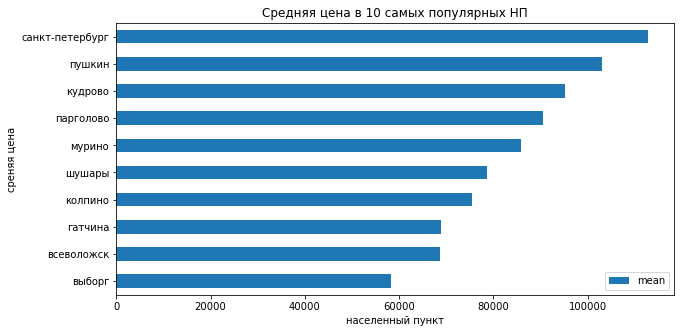

In [89]:
top_10_data.sort_values(by='mean').plot(kind='barh', y='mean', figsize=(10,5))
plt.title('Средняя цена в 10 самых популярных НП')
plt.xlabel('населенный пункт')
plt.ylabel('среняя цена')
plt.show()

Самая высокая цена за квадратный метр - в Санкт-Петербруге. А самая низкая среди топ-10 в Выборге, ведь он находится дальше всех от Петербурга.

 ####  Средня стоимость на разном удалении от центра Петербурга. 

In [90]:
(data.loc[data['locality_name']=='санкт-петербург']
    .pivot_table(index= data['city_centre_km'], values='last_price', aggfunc=['mean', 'count']))

,mean,count
,last_price,last_price
city_centre_km,,
0.0,2.048484e+07,21
1.0,1.391662e+07,169
2.0,1.296411e+07,274
3.0,9.919545e+06,322
4.0,1.088964e+07,644
5.0,1.161370e+07,845
6.0,1.204653e+07,568
7.0,1.273158e+07,397


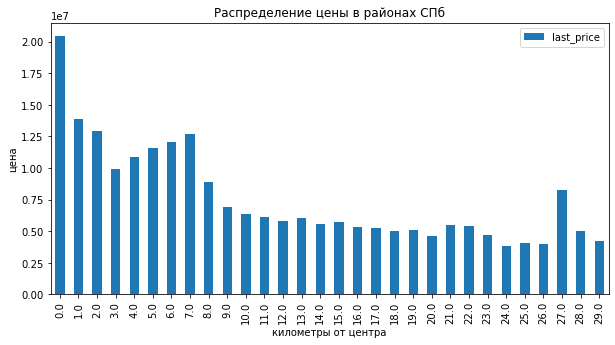

In [91]:
(data.loc[data['locality_name']=='санкт-петербург']
    .pivot_table(index= data['city_centre_km'], values='last_price')
    .plot(kind='bar', figsize=(10, 5)))
plt.title('Распределение цены в районах СПб')
plt.xlabel('километры от центра')
plt.ylabel('цена')
plt.show()

In [92]:
data.query('city_centre_km==27 and locality_name == "санкт-петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sq_meter,day_of_week,month,year,city_centre_km,floor_type
716,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,False,...,1496.0,0.0,NaN,128.0,193918.92,1,11,2017,27.0,другой
5760,6,2250000.0,32.0,2018-02-27,1,3.00,2,16.5,2,False,...,NaN,0.0,NaN,178.0,70312.50,1,2,2018,27.0,последний


Самая высокая цена, конечно, в самом центре Петербурга, затем она колеблется в пределах до 7 км, а после-снижается по мере удаленности от центра. Заметен выброс в районе 27 км. Такой километраж от центра - достаточно большой для Петербруга. Возможно район указан неверно. Можно заметить, что нужным параметрам (27 км от центра и город  Санкт-Петербург) соответствуют два объекта, цена которых 14350000 и 2250000 рублей. Как раз из-за первого мы наблюдаем выброс.

In [93]:
grouped = data.groupby(['floor_type', 'city_centre_km']).agg(count=('floor_type', 'count')).reset_index()
km_3_5 = grouped[(grouped['city_centre_km'] == 3) | (grouped['city_centre_km'] == 5)]
total_counts = km_3_5.groupby('city_centre_km')['count'].transform('sum')
km_3_5['percentage'] = (km_3_5['count'] / total_counts).round(decimals=2)
print(km_3_5)

    floor_type  city_centre_km  count  percentage
3       другой             3.0    196        0.61
5       другой             5.0    642        0.76
58      первый             3.0     52        0.16
60      первый             5.0     75        0.09
112  последний             3.0     74        0.23
114  последний             5.0    128        0.15


<ipython-input-93-9e253999e9d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  km_3_5['percentage'] = (km_3_5['count'] / total_counts).round(decimals=2)


На 3 километре продается заметно меньше квартир с типом этажа "другой" - всего 61%, в то время как на 5 уилометре от центра квартир с таким типом этажа 76%. Соответственно, из-за того, что квартиры на первом и последнем этажах стоят дешевле, мы видим провал в цене на 3-ем километре от центра.

### Общий вывод

Проект состоял из нескольких этапов. Сначала данные были изучены, после чего была сделана предобработка (удалены или заменены некоторые пропущенные значения, заменены неявные дубликаты, изменены типы данных, где это требовалось). Затем обработаны аномальные значения. Также обнаружено, что данные во многих столбцах выходят за рамки нормального распределения, однако выбросами их нельзя считать, т.к. возможно это жилье более высокого класса (например, общая площадь более 200 м**2). 

После подготовки данных было изучено, сколько времени занимает продажа квартиры. Получены следующие результаты: В основном большинство квартир продается до 100 дней, но есть и слишком быстрые продажи - до 45 дней, а также и слишком долгие - более 230 дней. Благодаря гистограмме заметно, что многие квартиры снимают с продажи через 45, 60 или 90, возможно это связано с особенностями платформы. 

Затем была проанлализирована зависимость цены объекта от ряда факторов. Среди более значимых можно выделить следующие: общая площадь, жилая площадь, количество комнат, площадь кухни (логично, ведь эти параметры тоже связаны между собой). 

На графике можно увидеть, что цены на квартиры, расположенные на первом или последнем этажах ниже. День недели или месяц публикации не сильно влияют на цену, в отличие от года. Можно наблюдать, что в 2014 году были самые высокие цены на недвижимость, а после - резко упали. Но также необходимо отметить, что и площадь продаваемых квартир в 2014 году была намного больше, а с течением времени - сильно снизилась.

Также выделены топ-10 населенных пунктов с большим количеством объявлений и указана стоимость жилья за 1 квадратный метр. Среди них - город Санкт-Петербруг и ближайшие к нему города и поселки. Среди них в Санкт-Петербруге самая высокая стоимость за 1 м**2, а в Выборге самая маленькая (он и находится дальше всех от Петербурга).

Проанализирована цена и в районах Санкт-Петербурга. Самая высокая цена наблюдается в центре - на расстоянии 1 километра. После 7 километров от центра цена на жилье падает, однако наблюдается пик на расстоянии 27 км.  К нему привела одна запись - квартира, стоимостью 14.350.000 рублей. Также на 3-ем километре от центра из-за большого количества квартир, расположенных на первом или последнем этажах, заметен спад в цене.